## Analysis of Unrestrained Fully Coupled Trajectory to Generate Parameters for Restraints

To create the environment required for this notebook, run

```bash
conda create -n biosimspace-dev -c conda-forge -c michellab/label/dev biosimspace
conda activate biosimspace-dev
```

### Get Ligand Heavy Atoms. Find Potential Anchor Points for Each

In [44]:
import MDAnalysis as mda
from MDAnalysis.analysis.distances import dist
from MDAnalysis.lib.distances import calc_dihedrals
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import nglview as nv

# FIXME: Replace with paths to your own trajectory and topology files
u = mda.Universe("find_restraints_input/SYSTEM.top", "find_restraints_input/traj_poseA.dcd")

lig_heavy = u.select_atoms("resname LIG and not name H*")

# anchors dict of dict. For each ligand heavy atom there is a dictionary of protein heavy atoms,
# for each of which there is a dictionary of average distance and standard deviation

anchors_dict = {}
for lig_atom in lig_heavy:
    for prot_atom in u.select_atoms(f"(protein or resname PRT) and (around 10 index {lig_atom.index}) and (not name H*)"): # protein does not recognise PRT
        anchors_dict[(lig_atom.index,prot_atom.index)]={}
        anchors_dict[(lig_atom.index, prot_atom.index)]["dists"]=[]
    

/home/finlayclark/anaconda3/envs/mamba/envs/biosimspace-dev-test/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


### Compute Average Distance and SD


In [45]:
for frame in u.trajectory:
    for lig_atom_index, prot_atom_index in anchors_dict.keys():
        distance = dist(mda.AtomGroup([u.atoms[lig_atom_index]]), mda.AtomGroup([u.atoms[prot_atom_index]]), box=frame.dimensions)[2][0]
        anchors_dict[(lig_atom_index,prot_atom_index)]["dists"].append(distance)

In [46]:
# change lists to numpy arrays
for pair in anchors_dict.keys():
    anchors_dict[pair]["dists"] = np.array(anchors_dict[pair]["dists"])

In [47]:
# calculate average and SD
for pair in anchors_dict.keys():
    anchors_dict[pair]["avg_dist"] = anchors_dict[pair]["dists"].mean()
    anchors_dict[pair]["sd_dist"] = anchors_dict[pair]["dists"].std()

In [48]:
# get n pairs with lowest SD
pairs_ordered_sd=[]
for item in sorted(anchors_dict.items(), key=lambda item: item[1]["sd_dist"]):
    pairs_ordered_sd.append(item[0])
    print(f'Pair: {item[0]}, av distance: {item[1]["avg_dist"]:.2f}, SD: {item[1]["sd_dist"]:.2f}')

Pair: (21, 4950), av distance: 2.72, SD: 0.12
Pair: (21, 4946), av distance: 4.85, SD: 0.15
Pair: (11, 4950), av distance: 3.64, SD: 0.15
Pair: (21, 4949), av distance: 3.37, SD: 0.15
Pair: (11, 4946), av distance: 5.92, SD: 0.15
Pair: (11, 4949), av distance: 4.51, SD: 0.16
Pair: (3, 4909), av distance: 3.63, SD: 0.18
Pair: (5, 4946), av distance: 8.27, SD: 0.18
Pair: (5, 4949), av distance: 6.87, SD: 0.18
Pair: (11, 4955), av distance: 8.79, SD: 0.18
Pair: (11, 4954), av distance: 7.96, SD: 0.18
Pair: (3, 4949), av distance: 5.67, SD: 0.18
Pair: (21, 4955), av distance: 7.74, SD: 0.18
Pair: (5, 4950), av distance: 6.01, SD: 0.18
Pair: (3, 4919), av distance: 3.67, SD: 0.18
Pair: (14, 4949), av distance: 7.10, SD: 0.19
Pair: (3, 4946), av distance: 7.12, SD: 0.19
Pair: (14, 4946), av distance: 8.40, SD: 0.19
Pair: (3, 4950), av distance: 4.91, SD: 0.19
Pair: (21, 4954), av distance: 7.02, SD: 0.19
Pair: (11, 65), av distance: 5.77, SD: 0.19
Pair: (11, 68), av distance: 8.15, SD: 0.19


In [49]:
# Print out pairs with lowest SD
print("The ligand-protein atom pairs with the lowest SD in distance are:")
for i in range(5):
    print(f"{u.atoms[pairs_ordered_sd[i][0]]} and {u.atoms[pairs_ordered_sd[i][1]]}")


The ligand-protein atom pairs with the lowest SD in distance are:
<Atom 22: OAA of type oh of resname LIG, resid 1 and segid SYSTEM> and <Atom 4951: OD1 of type O of resname ASN, resid 326 and segid SYSTEM>
<Atom 22: OAA of type oh of resname LIG, resid 1 and segid SYSTEM> and <Atom 4947: CB of type 2C of resname ASN, resid 326 and segid SYSTEM>
<Atom 12: CAP of type ca of resname LIG, resid 1 and segid SYSTEM> and <Atom 4951: OD1 of type O of resname ASN, resid 326 and segid SYSTEM>
<Atom 22: OAA of type oh of resname LIG, resid 1 and segid SYSTEM> and <Atom 4950: CG of type C of resname ASN, resid 326 and segid SYSTEM>
<Atom 12: CAP of type ca of resname LIG, resid 1 and segid SYSTEM> and <Atom 4947: CB of type 2C of resname ASN, resid 326 and segid SYSTEM>


In [50]:
view3 = nv.show_mdanalysis(u)
#view3.add_representation('licorice', selection="resname LIG", color='orange')
view3.update_representation('licorice', selection='ligand', color='blue')
view3

NGLWidget(max_frame=299)

### For Pairs with Lowest Pairwise RMSDs, find Adjacent Heavy Atoms

In [51]:
def get_anchor_ats(a1_idx,u):
    """Takes in index of anchor atom 1 and universe and returns
    list of all three anchor atoms, which are chosen to be bonded
    and not H"

    Args:
        a1_idx (int): Index of the first anchor atom
        u (mda universe): The mda universe

    Returns:
        ints: The indices of all three anchor points
    """

    a1_at = u.atoms[a1_idx]
    bonded_heavy_at = a1_at.bonded_atoms.select_atoms("not name H*")
    a2_idx = bonded_heavy_at[0].index

    if len(bonded_heavy_at)>1:
        # not at end of chain
        a3_idx = bonded_heavy_at[1].index
        # Might be better to return all possible combinations
    else:
        # at end of chain, get next heavy atom along
        a3_idx = bonded_heavy_at[0].bonded_atoms.select_atoms("not name H*")[1].index
        # Check that we have not just moved back to first atom
        if a3_idx == a1_idx: 
            a3_idx = bonded_heavy_at[0].bonded_atoms.select_atoms("not name H*")[0].index

    return a1_idx, a2_idx, a3_idx

In [52]:
print(get_anchor_ats(pairs_ordered_sd[0][0],u))
print(get_anchor_ats(pairs_ordered_sd[0][1],u))

(21, 11, 3)
(4950, 4949, 4946)


### Use These As Anchors and Plot Variance of Associated Degrees of Freedom

In [53]:
def get_distance(idx1, idx2, u):
    """ Distance in Angstrom"""
    distance = dist(mda.AtomGroup([u.atoms[idx1]]), mda.AtomGroup([u.atoms[idx2]]), box=u.dimensions)[2][0]
    return distance

In [54]:
def get_angle(idx1, idx2, idx3, u):
    """Angle in rad"""
    C = u.atoms[idx1].position 
    B = u.atoms[idx2].position 
    A = u.atoms[idx3].position 
    BA = A - B
    BC = C - B
    angle = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return angle

In [55]:
def get_dihedral(idx1, idx2, idx3, idx4, u):
    """Dihedral in rad"""
    positions =[u.atoms[idx].position for idx in [idx1,idx2,idx3,idx4]]
    dihedral = calc_dihedrals(positions[0], positions[1], positions[2], positions[3], box = u.dimensions)
    return dihedral



In [56]:
def get_boresch_dof(l1,l2,l3,r1,r2,r3,u):
    """Calculate Boresch degrees of freedom from indices of anchor atoms"""
    # Ordering of connection of anchors is r3,r2,r1,l1,l2,l3
    r = get_distance(r1,l1,u)
    thetaA = get_angle(r2,r1,l1,u)
    thetaB = get_angle(r1,l1,l2,u)
    phiA = get_dihedral(r3,r2,r1,l1,u)
    phiB = get_dihedral(r2,r1,l1,l2,u)
    phiC = get_dihedral(r1,l1,l2,l3,u)
    # Not restrained but distance from coolinearity must be checked
    thetaR = get_angle(r3,r2,r1,u) # Receptor internal angle
    thetaL = get_angle(l1,l2,l3,u) # Ligand internal angle
    return r, thetaA, thetaB, phiA, phiB, phiC, thetaR, thetaL


In [57]:
lig_anchors = get_anchor_ats(pairs_ordered_sd[0][0],u)
prot_anchors = get_anchor_ats(pairs_ordered_sd[0][1],u)
get_boresch_dof(lig_anchors[0],lig_anchors[1],lig_anchors[2],prot_anchors[0],prot_anchors[1],prot_anchors[2],u)

(2.6736129266912014,
 1.7660948,
 2.1968734,
 -2.5280293156218536,
 3.022192487949297,
 0.2523941426977725,
 2.1379848,
 2.1233063)

In [58]:
# get values of degrees of freedom for lowest SD pairs across whole trajectory

boresch_dof_dict = {}
for pair in pairs_ordered_sd[:200]:
    boresch_dof_dict[pair]={}
    l1_idx, r1_idx = pair
    _, l2_idx, l3_idx = get_anchor_ats(l1_idx,u)
    _, r2_idx, r3_idx = get_anchor_ats(r1_idx,u)
    boresch_dof_dict[pair]["anchor_ats"]=[l1_idx,l2_idx,l3_idx,r1_idx,r2_idx,r3_idx]

    boresch_dof_list = ["r","thetaA","thetaB","phiA","phiB","phiC","thetaR","thetaL"]

    # Add sub dictionaries for each Boresch degree of freedom
    for dof in boresch_dof_list:
        boresch_dof_dict[pair][dof]={}
        boresch_dof_dict[pair][dof]["values"]=[]

    # Populate these dictionaries with values from trajectory
    n_frames = len(u.trajectory)

    for i, frame in enumerate(u.trajectory):
        r, thetaA, thetaB, phiA, phiB, phiC, thetaR, thetaL = get_boresch_dof(l1_idx,l2_idx,l3_idx,r1_idx,r2_idx,r3_idx,u)
        boresch_dof_dict[pair]["r"]["values"].append(r)
        boresch_dof_dict[pair]["thetaA"]["values"].append(thetaA)
        boresch_dof_dict[pair]["thetaB"]["values"].append(thetaB)
        boresch_dof_dict[pair]["phiA"]["values"].append(phiA)
        boresch_dof_dict[pair]["phiB"]["values"].append(phiB)
        boresch_dof_dict[pair]["phiC"]["values"].append(phiC)
        boresch_dof_dict[pair]["thetaR"]["values"].append(thetaR)
        boresch_dof_dict[pair]["thetaL"]["values"].append(thetaL)

        if i == n_frames-1:
            boresch_dof_dict[pair]["tot_var"]=0
            for dof in boresch_dof_list:
                boresch_dof_dict[pair][dof]["values"]=np.array(boresch_dof_dict[pair][dof]["values"])
                boresch_dof_dict[pair][dof]["avg"]=boresch_dof_dict[pair][dof]["values"].mean()
                # For dihedrals, compute variance and mean based on list of values corrected for periodic boundary at 
                # pi radians, because there is no problem with dihedrals in this region. Should have been done with 
                # circmean from scipy - this is used in later implementations e.g. in BioSimSpace
                if dof[:3] == "phi":
                    avg = boresch_dof_dict[pair][dof]["avg"]

                    # correct variance - fully rigorous
                    corrected_values_sd = []
                    for val in boresch_dof_dict[pair][dof]["values"]:
                        dtheta = abs(val - avg)
                        corrected_values_sd.append(min(dtheta, 2*np.pi-dtheta))
                    corrected_values_sd = np.array(corrected_values_sd) 
                    boresch_dof_dict[pair][dof]["sd"]=corrected_values_sd.std()

                    # Correct mean (will fail if very well split above and below 2pi)
                    # get middle of interval based on current mean
                    corrected_values_avg=[]
                    periodic_bound = avg - np.pi
                    if periodic_bound < -np.pi:
                        periodic_bound+=2*np.pi
                    # shift vals from below periodic bound to above
                    for val in boresch_dof_dict[pair][dof]["values"]:
                        if val < periodic_bound:
                            corrected_values_avg.append(val+2*np.pi)
                        else:
                            corrected_values_avg.append(val)
                    corrected_values_avg = np.array(corrected_values_avg)
                    mean_corrected = corrected_values_avg.mean()
                    #shift mean back to normal range
                    if mean_corrected > np.pi:
                        boresch_dof_dict[pair][dof]["avg"]=mean_corrected-2*np.pi
                    else:
                        boresch_dof_dict[pair][dof]["avg"]=mean_corrected
                        
                else:
                    boresch_dof_dict[pair][dof]["sd"]=boresch_dof_dict[pair][dof]["values"].std()
                # Exclude variance of internal angles as these are not restrained
                if (dof != "thetaR" and dof != "thetaL"):
                    boresch_dof_dict[pair]["tot_var"]+=boresch_dof_dict[pair][dof]["sd"]**2
                # Assume Gaussian distributions and calculate force constants for harmonic potentials
                # so as to reproduce these distributions
                boresch_dof_dict[pair][dof]["k"]=0.593/(boresch_dof_dict[pair][dof]["sd"]**2) # RT at 289 K is 0.593 kcal mol-1


In [59]:
boresch_dof_dict

{(21, 4950): {'anchor_ats': [21, 11, 3, 4950, 4949, 4946],
  'r': {'values': array([2.67361293, 3.13587866, 2.63410402, 2.7454901 , 2.58066296,
          2.80861679, 2.73008874, 2.5230102 , 2.58526228, 2.70528145,
          2.75813372, 2.68557962, 2.66523574, 2.61947035, 2.71831089,
          3.08714239, 2.60195205, 3.03162355, 2.76850365, 2.96110635,
          2.62175133, 2.73024408, 2.77556409, 2.68979702, 2.59935358,
          2.74834684, 2.85465137, 2.68185054, 2.65000578, 2.75688185,
          2.68996447, 2.70623325, 2.61274588, 2.58273985, 2.60539515,
          2.68760424, 2.61617038, 2.7284924 , 2.73713272, 2.65890744,
          2.65657433, 2.58526721, 2.67005415, 2.68191961, 2.56200874,
          2.7474366 , 2.66382955, 2.6808681 , 2.64374521, 2.61282063,
          2.65967561, 2.77909972, 2.58245989, 2.6869637 , 2.71652622,
          2.5631322 , 2.68738377, 2.57882717, 2.74053589, 2.7487661 ,
          2.63267585, 2.57453686, 2.80984747, 2.7104257 , 2.70791647,
          2.9459

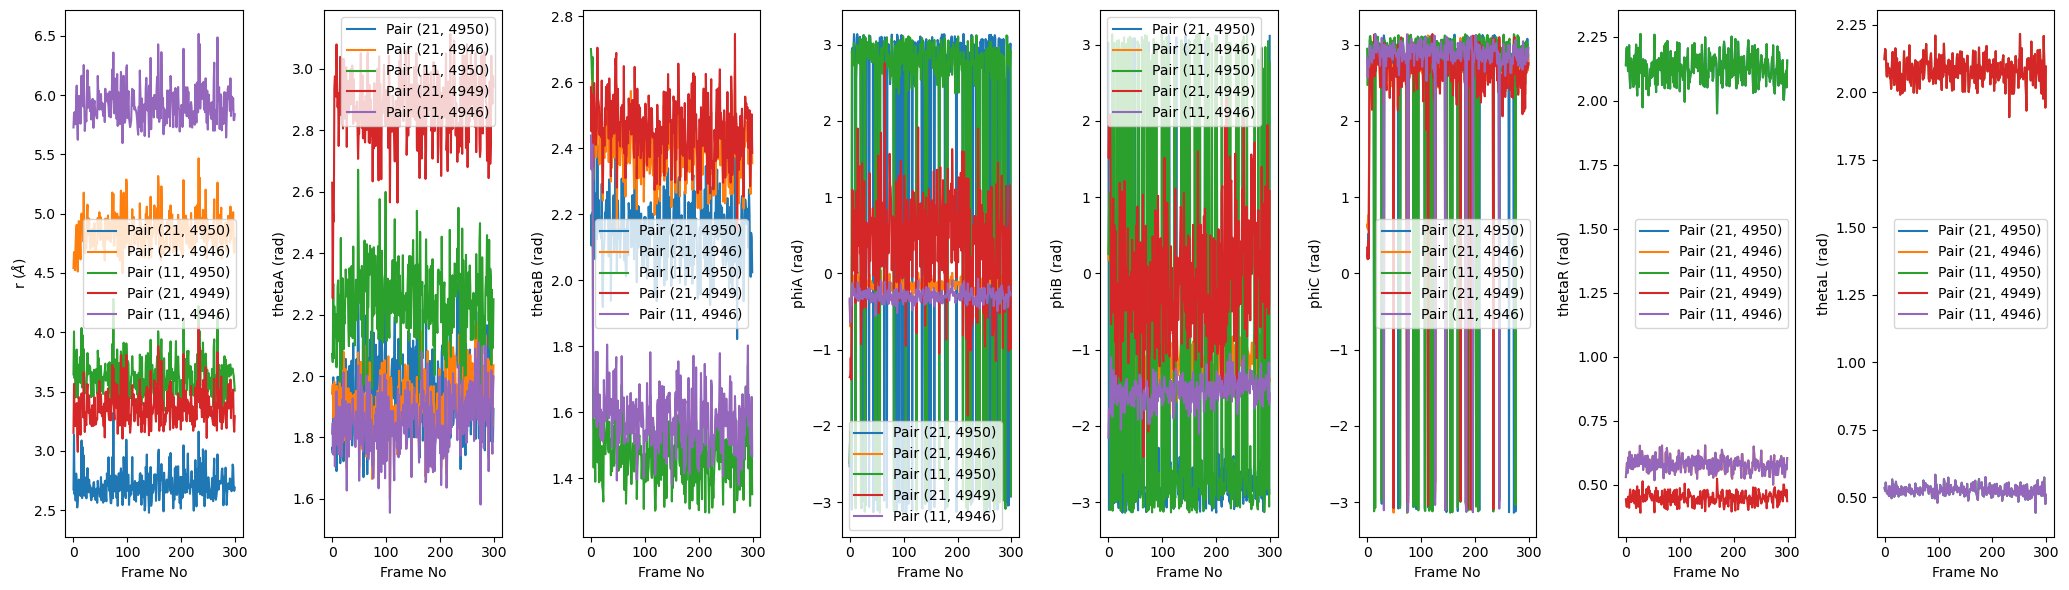

In [60]:
#boresch_dof_list = ["r","thetaA","thetaB","phiA","phiB","phiC","thetaR","thetaL"]
boresch_dof_list = ["r","thetaA","thetaB","phiA","phiB","phiC","thetaR","thetaL"]

# Plot avg and sd of dof for Boresch dof from top 10 lowest SD pairs

num_pairs = 5
n_dof = len(boresch_dof_list)

fig, axs = plt.subplots(1,n_dof, figsize=(2.6*n_dof,6))
for i, dof in enumerate(boresch_dof_list):
    for j, pair in enumerate(boresch_dof_dict.keys()):
        axs[i].plot([x for x in range(300)], boresch_dof_dict[pair][dof]["values"],label=f"Pair {pair}")
        if dof == "r":
            axs[i].set_ylabel("r ($\AA$)")
        else:
            axs[i].set_ylabel(f"{dof} (rad)")
        if j == num_pairs-1:
            break
    axs[i].set_xlabel("Frame No")
    axs[i].legend()
fig.tight_layout()



### Filter, Pick Optimum Degrees of Freedom and Select Force Constants Based on Variance, Select Equilibrium Values

In [61]:
# Order pairs according to variance 
pairs_ordered_boresch_var=[]
for item in sorted(boresch_dof_dict.items(), key=lambda item: item[1]["tot_var"]):
    pairs_ordered_boresch_var.append(item[0])
    print(f'Pair: {item[0]}, total variance: {boresch_dof_dict[item[0]]["tot_var"]}')

# Filter out r <1, theta >150 or < 30 
selected_pairs_boresch = []
for pair in pairs_ordered_boresch_var:
    cond_dist = boresch_dof_dict[pair]["r"]["avg"] > 1
    avg_angles =[]
    #angles = ["thetaA", "thetaB", "thetaR","thetaL"] # also check internal angles
    angles = ["thetaA", "thetaB"] # May also be good to check internal angles
    for angle in angles:
        avg_angles.append(boresch_dof_dict[pair][angle]["avg"])
    cond_angles = list(map(lambda x: (x<2.62 and x >0.52),avg_angles))
    if cond_dist and all(cond_angles):
        selected_pairs_boresch.append(pair)

print(selected_pairs_boresch)


Pair: (11, 4946), total variance: 0.07429871428171066
Pair: (11, 4944), total variance: 0.07732783244663065
Pair: (20, 4946), total variance: 0.0782600207161005
Pair: (14, 4946), total variance: 0.0784974502882192
Pair: (5, 963), total variance: 0.07883068261466526
Pair: (11, 4955), total variance: 0.08136008702720131
Pair: (10, 935), total variance: 0.08408891672876272
Pair: (20, 4944), total variance: 0.08434272939497105
Pair: (2, 1615), total variance: 0.08466409524171511
Pair: (3, 963), total variance: 0.08542369478263358
Pair: (10, 950), total variance: 0.08645639096445037
Pair: (5, 965), total variance: 0.09032204447685646
Pair: (2, 4919), total variance: 0.090463490630306
Pair: (11, 84), total variance: 0.0906413206821633
Pair: (11, 65), total variance: 0.09078947880872615
Pair: (4, 4919), total variance: 0.09156725318549602
Pair: (2, 4917), total variance: 0.0923051444128111
Pair: (3, 84), total variance: 0.09297728031550008
Pair: (4, 4917), total variance: 0.0937644464504741
P

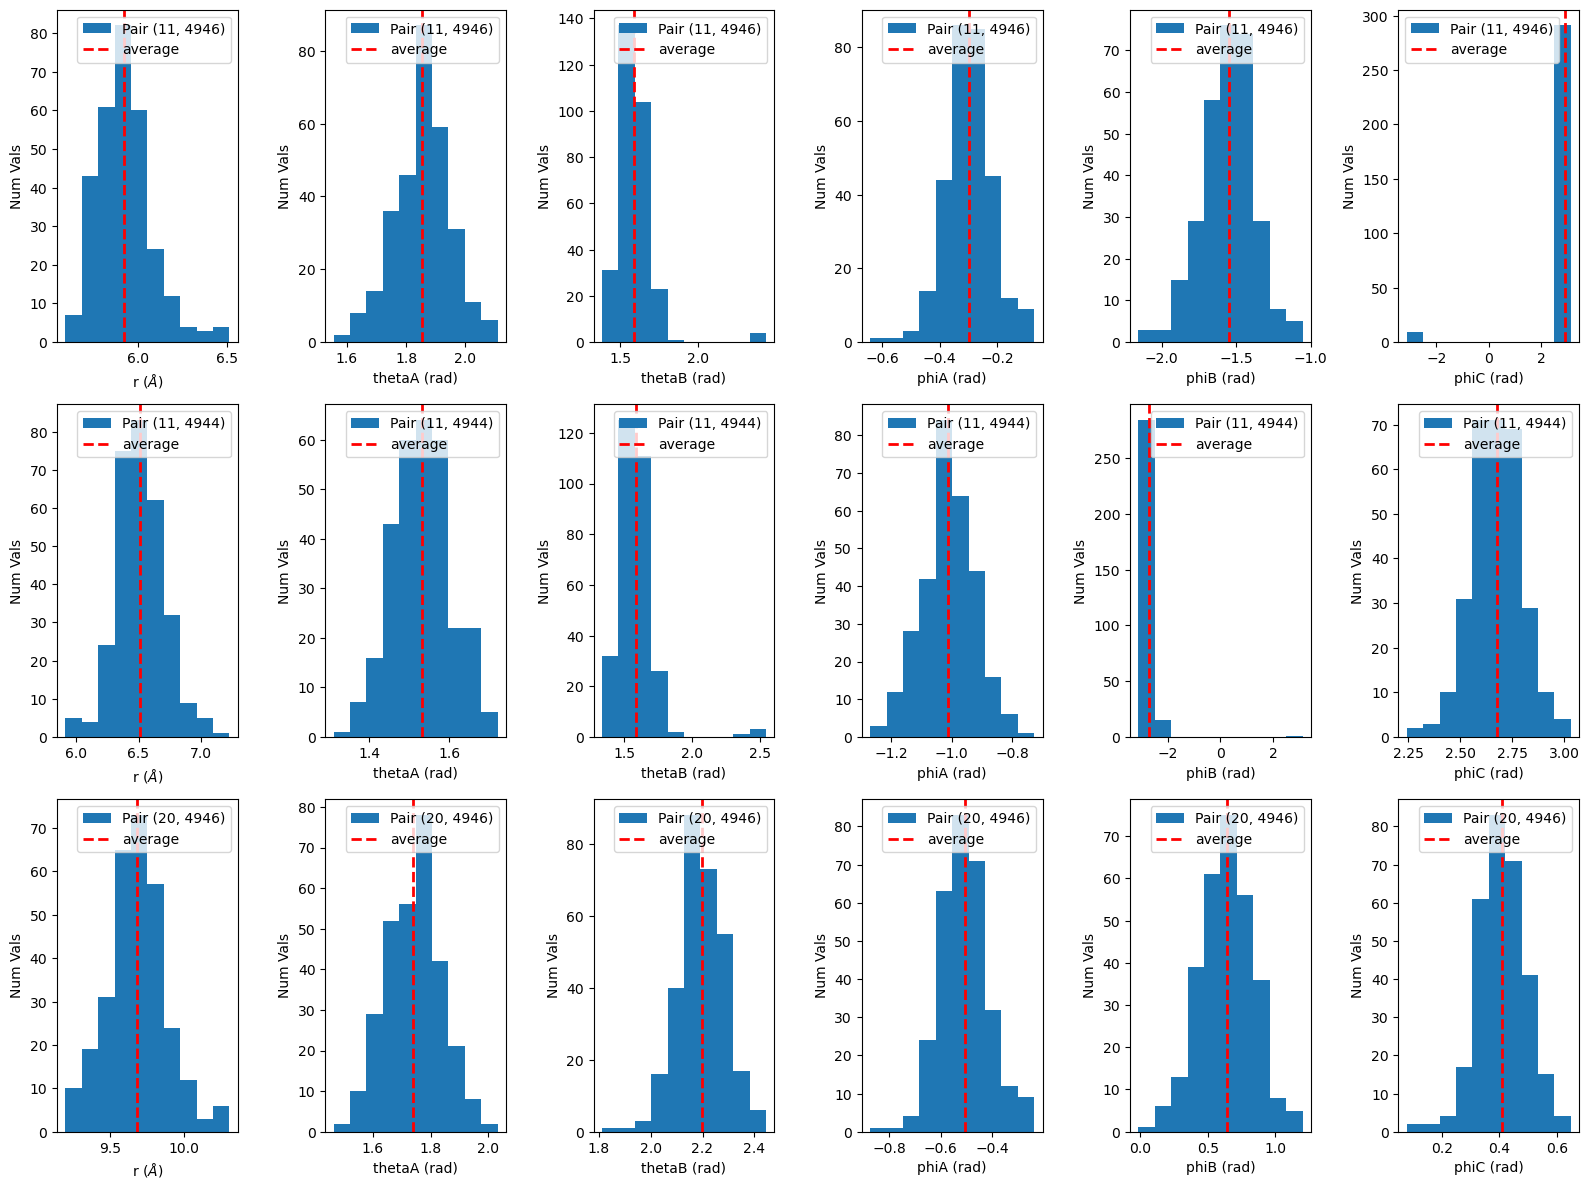

In [62]:
# Plot histograms

fig, axs = plt.subplots(len(selected_pairs_boresch[:3]),6, figsize=(16,4*len(selected_pairs_boresch[:3])))
for pair_idx, pair in enumerate(selected_pairs_boresch[:3]):
    #pair_idx=0
    for i, dof in enumerate(["r","thetaA","thetaB","phiA","phiB","phiC"]):
        axs[pair_idx][i].hist(boresch_dof_dict[pair][dof]["values"],bins=10,label=f"Pair {pair}")
        axs[pair_idx][i].axvline(x=boresch_dof_dict[pair][dof]["avg"], color='r', linestyle='dashed', linewidth=2,label="average")
        if dof == "r":
            axs[pair_idx][i].set_xlabel("r ($\AA$)")
        else:
            axs[pair_idx][i].set_xlabel(f"{dof} (rad)")
        axs[pair_idx][i].set_ylabel("Num Vals")
        axs[pair_idx][i].legend()
fig.tight_layout()


In [63]:
# Print out Boresch parameters - note that force constants are halved to be consistent with
# the definition of force constants as E = kx**2 (rather than 0.5*k*x**2) used in SOMD.

def print_boresch_params(pair):
    l1 = boresch_dof_dict[pair]["anchor_ats"][0]
    l2 = boresch_dof_dict[pair]["anchor_ats"][1]
    l3 = boresch_dof_dict[pair]["anchor_ats"][2]
    r1 = boresch_dof_dict[pair]["anchor_ats"][3]
    r2 = boresch_dof_dict[pair]["anchor_ats"][4]
    r3 = boresch_dof_dict[pair]["anchor_ats"][5]
    r0 = boresch_dof_dict[pair]["r"]["avg"]
    thetaA0 = boresch_dof_dict[pair]["thetaA"]["avg"]
    thetaB0 = boresch_dof_dict[pair]["thetaB"]["avg"]
    phiA0 = boresch_dof_dict[pair]["phiA"]["avg"]
    phiB0 = boresch_dof_dict[pair]["phiB"]["avg"]
    phiC0 = boresch_dof_dict[pair]["phiC"]["avg"]
    kr = boresch_dof_dict[pair]["r"]["k"] / 2
    kthetaA = boresch_dof_dict[pair]["thetaA"]["k"] / 2
    kthetaB = boresch_dof_dict[pair]["thetaB"]["k"] / 2
    kphiA = boresch_dof_dict[pair]["phiA"]["k"] / 2
    kphiB = boresch_dof_dict[pair]["phiB"]["k"] / 2
    kphiC = boresch_dof_dict[pair]["phiC"]["k"] / 2

    print(f'{{"anchor_points":{{"r1":{r1}, "r2":{r2}, "r3":{r3}, "l1":{l1}, "l2":{l2}, "l3":{l3}}},\
    "equilibrium_values":{{"r0":{r0:.2f}, "thetaA0":{thetaA0:.2f}, "thetaB0":{thetaB0:.2f},"phiA0":{phiA0:.2f}, "phiB0":{phiB0:.2f}, "phiC0":{phiC0:.2f}}},\
    "force_constants":{{"kr":{kr:.2f}, "kthetaA":{kthetaA:.2f}, "kthetaB":{kthetaB:.2f}, "kphiA":{kphiA:.2f}, "kphiB":{kphiB:.2f}, "kphiC":{kphiC:.2f}}}}}')

In [64]:
print_boresch_params(selected_pairs_boresch[0])

{"anchor_points":{"r1":4946, "r2":4944, "r3":4949, "l1":11, "l2":2, "l3":3},    "equilibrium_values":{"r0":5.92, "thetaA0":1.85, "thetaB0":1.59,"phiA0":-0.30, "phiB0":-1.55, "phiC0":2.90},    "force_constants":{"kr":12.75, "kthetaA":33.37, "kthetaB":19.20, "kphiA":107.68, "kphiB":24.62, "kphiC":24.90}}
